# Correlation Analysis of UCSB Course Enrollment and Programming Comfort Levels

## Introduction

This notebook explores how taking specific UCSB courses relates to students’ self-reported programming comfort levels.  
Using data from the class survey dataset (`background-clean.csv`), we investigate whether enrollment in each course (coded as 1 if taken, 0 if not) correlates with higher programming comfort ratings (on a 1–5 scale).  

To capture relationships between ordinal and binary variables, we compute **Spearman’s ρ**, **Kendall’s τ-b**, and **Point-Biserial (Pearson)** correlations for each course.  
We also calculate mean comfort differences between students who took and did not take each course, then visualize the strongest associations.  

The goal is to identify which courses most strongly align with greater programming confidence, providing insight into how different academic experiences may shape comfort with coding.


## Methods

Because the dataset includes an **ordinal** outcome variable (`prog.comf`, rated 1–5) and **binary** predictors (each course: 1 = taken, 0 = not taken), standard Pearson correlation isn’t ideal.  
Instead, this analysis uses three complementary correlation measures designed for ordinal and binary data:

1. **Spearman’s ρ (rho):**  
   - A *rank-based* measure of association that assesses whether higher course participation values tend to correspond to higher comfort ratings.  
   - It does not assume a linear relationship, only a monotonic one (i.e., as one increases, the other generally increases).  
   - This is the **primary measure** used in this notebook.

2. **Kendall’s τ-b (tau-b):**  
   - Another rank-based measure that counts concordant and discordant pairs.  
   - It’s more conservative and robust when there are many tied values, which often occurs with Likert-scale responses.

3. **Point-Biserial (Pearson) correlation:**  
   - A special case of the Pearson correlation that works when one variable is binary and the other is continuous or treated as interval.  
   - Included here mainly for comparison to traditional correlation methods.

For each course, we:
- Calculated all three correlation coefficients and their p-values.  
- Computed mean programming comfort for students who took the course and those who didn’t.  
- Visualized the results in sorted bar charts to highlight which courses are most strongly associated with higher comfort levels.

These analyses were implemented in Python using **pandas**, **NumPy**, **SciPy**, and **Seaborn**, ensuring transparent and reproducible computation.


In [24]:
#!pip3 install pandas
#!pip3 install matplotlib
#!pip3 install scipy
#!pip3 install seaborn

### Step 1: Import libraries
We’ll use:
- **pandas** → load and clean our CSV data  
- **NumPy** → handle arrays and numeric conversions  
- **SciPy** → compute correlation statistics (Spearman, Kendall, Pearson)


In [17]:
import pandas as pd
import numpy as np
from scipy import stats

### Step 2: Load the dataset
Read the cleaned background survey data into a pandas DataFrame.
Then select only the columns we care about: the programming-comfort variable and all the course indicators.


In [18]:
df = pd.read_csv("/Users/annagornyitzki/DSCapstone/group-project_class-survey/module-0-class-survey-data-table2/data/background-clean.csv")

cols = [
    "prog.comf","PSTAT100","PSTAT115","PSTAT120","PSTAT122","PSTAT126","PSTAT131","PSTAT160",
    "PSTAT174","CS9","CS16","LING104","LING110","LING111","CS130","CS165","ECON145","PSTAT127",
    "PSTAT134","CS5"
]

# Keep only columns that actually exist in the file
present = [c for c in cols if c in df.columns]
df = df.loc[:, present].copy()

### Step 3: Clean and standardize columns
- Convert `prog.comf` to numeric (values 1–5).  
- Convert each course column to 0/1 integers:
  - 1 = student took the course  
  - 0 = did not take the course


In [19]:
df["prog.comf"] = pd.to_numeric(df["prog.comf"], errors="coerce")
df = df[df["prog.comf"].notna()].copy()

# Convert course columns to 0/1
for c in present:
    if c == "prog.comf":
        continue
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)
    df[c] = (df[c] != 0).astype(int)

### Step 4: Sanity checks
Confirm all columns are pandas Series and not accidentally shadowing built-in DataFrame methods (which can cause weird errors later).


In [20]:
for c in df.columns:
    if callable(getattr(df, c, None)):
        print(f"⚠️  Column name '{c}' is also a DataFrame method—use df['{c}'] syntax explicitly.")
    if not isinstance(df[c], pd.Series):
        print(f"⚠️  Column {c} is not a pandas Series; type = {type(df[c])}")


### Step 5: Define `corr_summary()`  
This function:
1. Converts inputs to numeric arrays.  
2. Drops missing values.  
3. Computes three correlation coefficients:  
   - **Spearman’s ρ** (rank-based)  
   - **Kendall’s τ-b** (rank-based)  
   - **Point-Biserial (Pearson)**  
4. Calculates mean comfort levels for students who *took* vs *did not take* the course.


In [21]:
def corr_summary(series_x, series_y):
    """
    Compute correlations and group stats between binary x and ordinal y.
    Converts inputs to NumPy arrays and masks NaNs to avoid subscript issues.
    """
    x = pd.to_numeric(series_x, errors="coerce").to_numpy()
    y = pd.to_numeric(series_y, errors="coerce").to_numpy()

    mask = np.isfinite(y) & np.isfinite(x)
    x = x[mask].astype(int)
    y = y[mask]

    rho, p_rho = stats.spearmanr(x, y)
    tau, p_tau = stats.kendalltau(x, y)
    r_pb, p_pb = stats.pearsonr(x, y)

    took = (x == 1)
    not_took = (x == 0)
    mean_if_took = y[took].mean() if took.any() else np.nan
    mean_if_not = y[not_took].mean() if not_took.any() else np.nan
    diff = mean_if_took - mean_if_not if took.any() and not_took.any() else np.nan

    return {
        "Spearman_rho": rho,
        "Spearman_p": p_rho,
        "Kendall_tau_b": tau,
        "Kendall_p": p_tau,
        "PointBiserial_r": r_pb,
        "PointBiserial_p": p_pb,
        "Mean_if_took": mean_if_took,
        "Mean_if_not": mean_if_not,
        "Mean_diff": diff,
        "n_took": int(took.sum()),
        "n_not": int(not_took.sum()),
    }


### Step 6: Compute correlations for every course
Loop through each course column, call `corr_summary()`, and collect results into a single DataFrame.  
Then sort by Spearman’s ρ to see which courses have the strongest positive correlation with comfort.


In [22]:
course_cols = [c for c in df.columns if c != "prog.comf"]
rows = []

for c in course_cols:
    stats_row = corr_summary(df[c], df["prog.comf"])
    rows.append({"course": c, **stats_row})

results = pd.DataFrame(rows).sort_values("Spearman_rho", ascending=False).reset_index(drop=True)
results


,course,Spearman_rho,Spearman_p,Kendall_tau_b,Kendall_p,PointBiserial_r,PointBiserial_p,Mean_if_took,Mean_if_not,Mean_diff,n_took,n_not
0,CS16,0.375881,0.006563,0.355093,0.007863,0.369802,0.007566,4.190476,3.633333,0.557143,21,30
1,CS130,0.243006,0.085752,0.229567,0.085740,0.238885,0.091368,4.400000,3.804348,0.595652,5,46
2,PSTAT134,0.237741,0.092977,0.224593,0.092747,0.231746,0.101770,4.333333,3.800000,0.533333,6,45
3,LING104,0.174971,0.219424,0.165294,0.216002,0.173633,0.223023,4.500000,3.836735,0.663265,2,49
4,PSTAT127,0.174971,0.219424,0.165294,0.216002,0.173633,0.223023,4.500000,3.836735,0.663265,2,49
5,LING111,0.174971,0.219424,0.165294,0.216002,0.173633,0.223023,4.500000,3.836735,0.663265,2,49
6,LING110,0.174971,0.219424,0.165294,0.216002,0.173633,0.223023,4.500000,3.836735,0.663265,2,49
7,CS165,0.158582,0.266364,0.149812,0.262142,0.152363,0.285808,4.250000,3.829787,0.420213,4,47
8,PSTAT160,0.130677,0.360709,0.123450,0.355472,0.113785,0.426596,3.933333,3.761905,0.171429,30,21
9,PSTAT100,0.125547,0.380030,0.118604,0.374673,0.142637,0.318039,4.000000,3.781250,0.218750,19,32


### Step 7: Plot correlations
Use Seaborn to create a horizontal bar chart showing each course’s Spearman correlation with programming comfort.
Positive values indicate that students who took the course tend to report higher comfort levels.


## Figure: Spearman’s ρ by Course (Strength & Direction)

**What this shows:**  
Each bar is the **Spearman rank correlation (ρ)** between taking a course (0/1) and programming comfort (1–5).  
- **Positive bars (to the right)** → students who took the course tend to report **higher** comfort.  
- **Negative bars (to the left)** → students who took the course tend to report **lower** comfort (rare).  
- The **farther from 0**, the **stronger** the monotonic association.

**Why Spearman’s ρ?**  
`prog.comf` is **ordinal** (Likert 1–5). Spearman correlates **ranks**, so it doesn’t assume equal spacing between 1,2,3,4,5 or linearity—just that comfort tends to move up (or down) as course-taking switches from 0→1.

**How to read it:**  
- Start at the **top bars** (largest ρ): these courses have the **strongest positive association** with comfort.  
- Values around **0.1–0.3** are small, **0.3–0.5** moderate, **>0.5** strong (rough rules of thumb; context matters).  
- A vertical dashed line at **0** separates positive from negative associations.

**Caveats:**  
Correlation ≠ causation. A higher ρ might reflect selection effects (e.g., more confident students choose certain courses) or co-enrollment patterns.


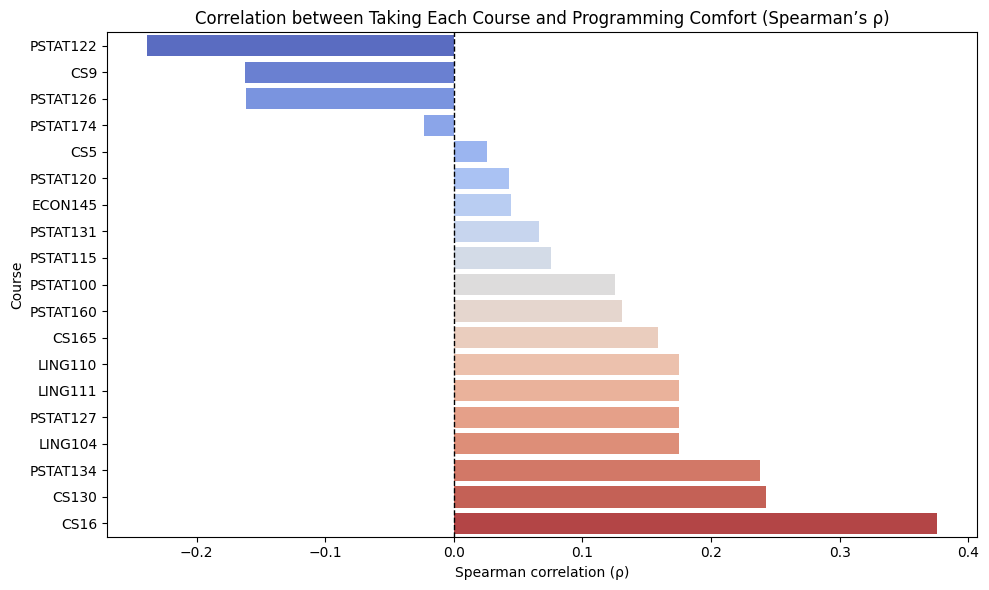

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort courses by Spearman correlation
results_sorted = results.sort_values("Spearman_rho", ascending=True)

plt.figure(figsize=(10,6))
sns.barplot(
    x="Spearman_rho",
    y="course",
    data=results_sorted,
    hue="course",           # add this line
    dodge=False,            # keeps bars in one column
    palette="coolwarm",
    legend=False            # no legend since each bar is its own course
)

plt.title("Correlation between Taking Each Course and Programming Comfort (Spearman’s ρ)")
plt.xlabel("Spearman correlation (ρ)")
plt.ylabel("Course")
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()


## Figure: Spearman’s ρ by Course (Strength & Direction)

**What this shows:**  
Each bar is the **Spearman rank correlation (ρ)** between taking a course (0/1) and programming comfort (1–5).  
- **Positive bars (to the right)** → students who took the course tend to report **higher** comfort.  
- **Negative bars (to the left)** → students who took the course tend to report **lower** comfort (rare).  
- The **farther from 0**, the **stronger** the monotonic association.

**Why Spearman’s ρ?**  
`prog.comf` is **ordinal** (Likert 1–5). Spearman correlates **ranks**, so it doesn’t assume equal spacing between 1,2,3,4,5 or linearity—just that comfort tends to move up (or down) as course-taking switches from 0→1.

**How to read it:**  
- Start at the **top bars** (largest ρ): these courses have the **strongest positive association** with comfort.  
- Values around **0.1–0.3** are small, **0.3–0.5** moderate, **>0.5** strong (rough rules of thumb; context matters).  
- A vertical dashed line at **0** separates positive from negative associations.

**Caveats:**  
Correlation ≠ causation. A higher ρ might reflect selection effects (e.g., more confident students choose certain courses) or co-enrollment patterns.


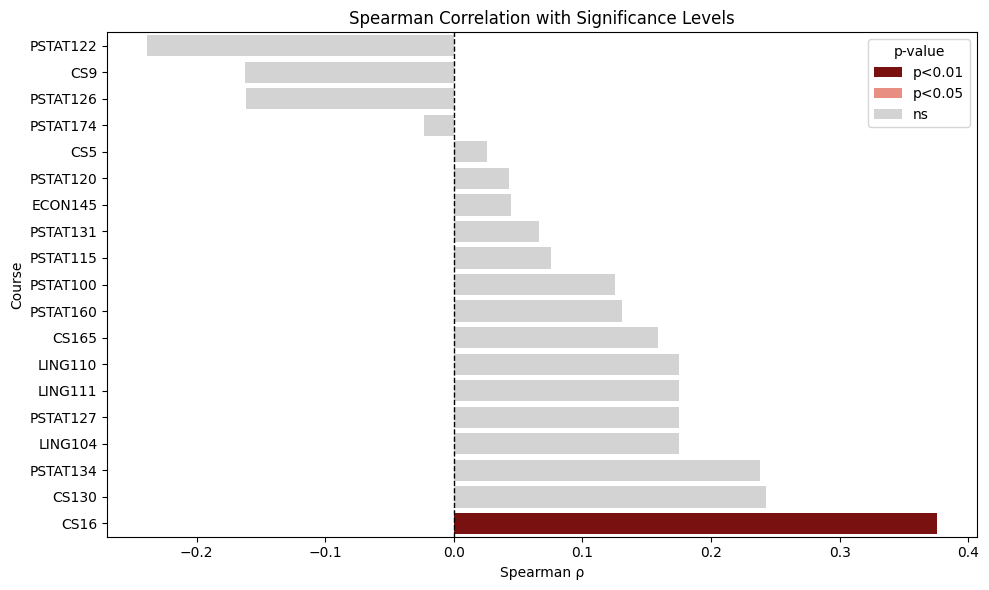

In [13]:
plt.figure(figsize=(10,6))
sns.barplot(
    x="Spearman_rho",
    y="course",
    data=results_sorted,
    hue=pd.cut(results_sorted["Spearman_p"], bins=[0,0.01,0.05,1], labels=["p<0.01","p<0.05","ns"]),
    dodge=False,
    palette={"p<0.01":"darkred","p<0.05":"salmon","ns":"lightgray"}
)

plt.title("Spearman Correlation with Significance Levels")
plt.xlabel("Spearman ρ")
plt.ylabel("Course")
plt.legend(title="p-value")
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()


## Figure: Mean Comfort Difference (Took – Did Not Take)

**What this shows:**  
For each course, the bar is **average comfort of takers minus non-takers** (in the original 1–5 units).  
- **Positive bars** → takers report higher comfort **by this many points** on average.  
- **Negative bars** → takers report lower comfort on average.

**Why include this?**  
It’s an **intuitive effect size** in **original units** (e.g., +0.6 points on a 1–5 scale). This complements correlation by showing **practical magnitude**, not just rank association.

**How to read it together with ρ:**  
- A course with **large positive mean difference** and **positive ρ** is a consistent, interpretable signal.  
- If mean difference is large but **not significant** (from the previous figure), you may have **small sample size** or **high variability** among takers.

**Caveats:**  
- Group sizes may be **imbalanced** (few takers → noisy means).  
- Mean differences don’t adjust for **co-enrollment** (confounding). For deeper inference, use **ordinal logistic regression** including multiple courses as predictors.


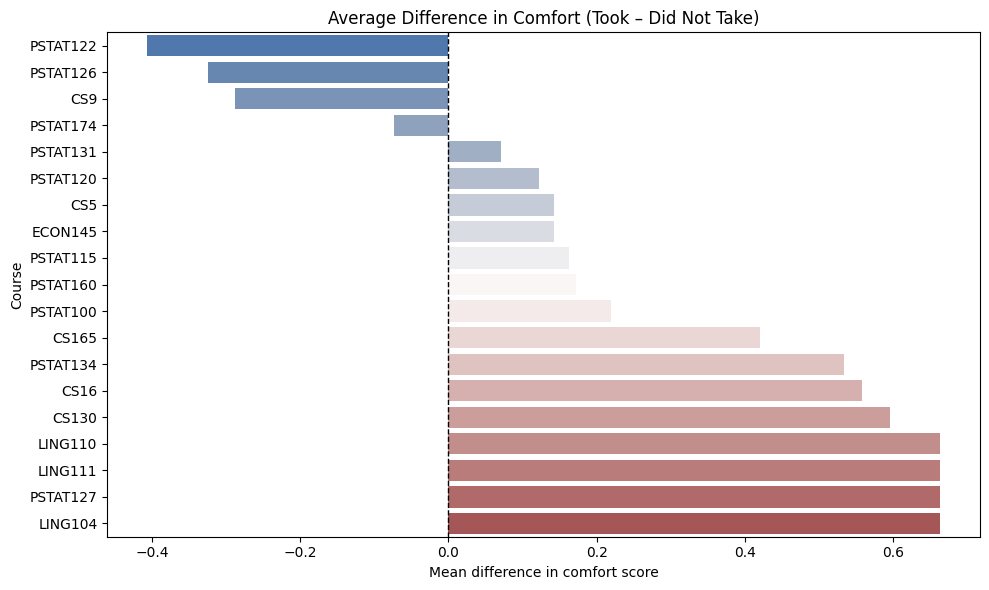

In [15]:
plt.figure(figsize=(10,6))
sns.barplot(
    x="Mean_diff", 
    y="course",
    hue="course",           # add this line
    dodge=False,            # keeps bars in one column
    data=results.sort_values("Mean_diff", ascending=True),
    palette="vlag"
)
plt.title("Average Difference in Comfort (Took – Did Not Take)")
plt.xlabel("Mean difference in comfort score")
plt.ylabel("Course")
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()
